In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn import metrics  
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv( './train_preprocessed.csv' )
train[ 'target' ] = np.log1p( train['price_doc'].values )

In [3]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=3, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain.target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          metrics = 'rmse',
                          verbose_eval = early_stopping_rounds,
                          nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        n_estimators = cvresult.shape[0]
        print( 'Best number of estimators {}'.format( n_estimators ) )
        alg.set_params( n_estimators = cvresult.shape[0] )
    
    #Fit the algorithm on the data
    alg.fit( dtrain[predictors], dtrain.target, eval_metric='rmse' )

In [4]:
predictors = [x for x in train.columns if x not in [ 'id', 'price_doc', 'target' ] ]
model = XGBRegressor(
    learning_rate = 0.05,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 3,
    gamma = 0,
    subsample = 1.0,
    colsample_bytree = 0.7,
    objective = 'reg:linear',
    scale_pos_weight = 1,
    nthread  = 8,
    seed = 42,
    reg_lambda = 10
)
modelfit( model, train, predictors )

C:\ProgramData\Anaconda2\lib\site-packages\xgboost-0.6-py2.7.egg\xgboost\sklearn.py:161: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\xgboost-0.6-py2.7.egg\xgboost\sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


[0]	train-rmse:14.3671+0.00193973	test-rmse:14.3671+0.00421084
[20]	train-rmse:5.18128+0.00045372	test-rmse:5.18128+0.00397735
[40]	train-rmse:1.91935+0.00070609	test-rmse:1.91985+0.00194981
[60]	train-rmse:0.817854+0.00213041	test-rmse:0.823635+0.00335539
[80]	train-rmse:0.514507+0.00356938	test-rmse:0.52989+0.00640872
[100]	train-rmse:0.451383+0.00362087	test-rmse:0.474632+0.00778566
[120]	train-rmse:0.435498+0.00326138	test-rmse:0.464651+0.00842024
[140]	train-rmse:0.427056+0.00332955	test-rmse:0.461722+0.00822794
[160]	train-rmse:0.421009+0.00307497	test-rmse:0.460594+0.00828252
[180]	train-rmse:0.416178+0.0025575	test-rmse:0.459891+0.00833237
[200]	train-rmse:0.411973+0.00240954	test-rmse:0.459461+0.00827219
[220]	train-rmse:0.407936+0.00211438	test-rmse:0.45914+0.00829212
[240]	train-rmse:0.404236+0.0020932	test-rmse:0.458892+0.00824215
[260]	train-rmse:0.400611+0.00220674	test-rmse:0.458746+0.00822712
[280]	train-rmse:0.397153+0.00203668	test-rmse:0.458668+0.00820453
[300]	train

In [5]:
# Следующий код перебирает наиболее значимые параметры. 
# Выполняется долго.
# Раскомментировать, если будет необходимость.
#param_test1 = {
# 'max_depth' : range(3,10,2),
# 'min_child_weight' : range(1,6,2)
# 'reg_lambda' : np.logspace(0, 3, num = 4 )
#}
#gsearch1 = GridSearchCV(estimator = model, 
#                        param_grid = param_test1, scoring = 'neg_mean_squared_error',
#                        n_jobs=8, iid=False, cv=3, verbose = True)
#gsearch1.fit( train[predictors], train.target )

#model = gsearch1.best_estimator_ 
# Выводим информацию о процессе.
#pd.DataFrame( gsearch1.cv_results_ )
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [6]:
# Уменьшаем learningRate и переобучаем классификатор
#model.set_params( learning_rate = 0.05, n_estimators = 1000 )
#modelfit( model, train, predictors )

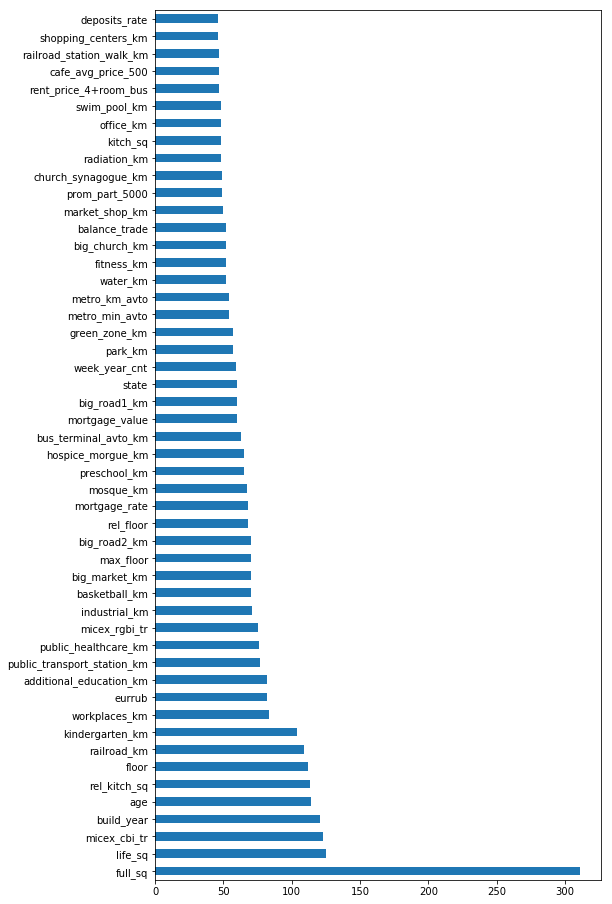

In [7]:
# Строим диаграмму важности признаков
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
f_score = pd.Series( model.get_booster().get_fscore(), name = 'F-score' )
f_score.sort_values( ascending = False, inplace = True )
# Оставляем топ 50 признаков.
f_score = f_score[:50]
f_score.plot.barh( ax = ax )

In [8]:
# Сохраняем файл с ошибками классификатора.

# Признаки берем только наиболее значимые.
most_important_features = list( f_score.index.values )
top_errors = train[ most_important_features + [ 'price_doc' ] ].copy()
prediction = model.predict( train[predictors] )
top_errors['predicted_price'] = np.exp( prediction ) - 1
top_errors['price_per_sqm'] = top_errors.price_doc / top_errors.full_sq
top_errors['squared_error'] = ( train.target - prediction )**2
top_errors.sort_values( 'squared_error', ascending = False, inplace = True )
top_errors = top_errors[:1000]
top_errors.to_excel( './top_errors.xls', index = True )

In [9]:
# Сохраняем модель
model.get_booster().save_model( './model' )